In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# !! need to insert this path to load h5py without errors!
#  (otherwise Python tries to load the h5py in default site-packages and throws an ImportError)
import sys
sys.path.insert(0, '/work2/08811/aew492/frontera/venv/illustris3.9/lib/python3.9/site-packages')

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

sys.path.insert(0, '/work2/08811/aew492/frontera/small-scale_cross-corrs/code')
from illustris_sim import TNGSim
import corrfuncs
import tools

### construct samples

In [6]:
# keep everything the same __except__ the type of galaxy: so we construct each galaxy sample
#  from the same simulation snapshot
z = 1.
sim = TNGSim('TNG300-3', redshift=z)

# galaxy number density: same for both
n = 2e-4

# DESI-like ELG:
# get the positions of the subhalos that we're counting as galaxies
gal_pos_elg = sim.subhalo_pos()[sim.gal_idx('ELG', 'DESI',
                                    n=n, verbose=True)]

# DESI-like LRG:
gal_pos_lrg = sim.subhalo_pos()[sim.gal_idx('LRG', 'DESI',
                                    n=n, verbose=True)]

input number density: 2.00e-04 (h/Mpc)^3
target number of subhalos: 1723
input number density: 2.00e-04 (h/Mpc)^3
target number of subhalos: 1723


In [15]:
gal_pos_elg.shape

(1723, 3)

In [22]:
# check if any galaxy positions are exactly the same ==> if the input number density is high enough then
#  the "ELG" and "LRG" regions of the sSFR cut will overlap
gal_pos_elg_ = [tuple(pos) for pos in gal_pos_elg]
gal_pos_lrg_ = [tuple(pos) for pos in gal_pos_lrg]
common_set = set(gal_pos_elg_) & set(gal_pos_lrg_)
assert len(common_set) == 0

### cross-correlation

In [38]:
# input parameters
rpmin = 0.1
rpmax = 60
nrpbins = 10
pimax_frac = 0.45
rmin = 0.1
rmax = 100
nbins = 10
nrepeats = 10
periodic = True
randmult = 3

pimax = int(pimax_frac * sim.boxsize.value)

In [40]:
ravg, wp_cross = corrfuncs.compute_wp_cross(gal_pos_elg, gal_pos_lrg, randmult, rpmin, rpmax, nbins, pimax,
                                      boxsize=sim.boxsize, zrange=None, logbins=True, periodic=periodic,
                                      nthreads=12, rr_fn=None, prints=True)

D1D2 calculated
D1R calculated
D2R calculated
RR calculated
3d counts converted to cf


Text(0.5, 1.0, 'ELG x LRG (n=2.0e-04 (h/Mpc)$^3$)')

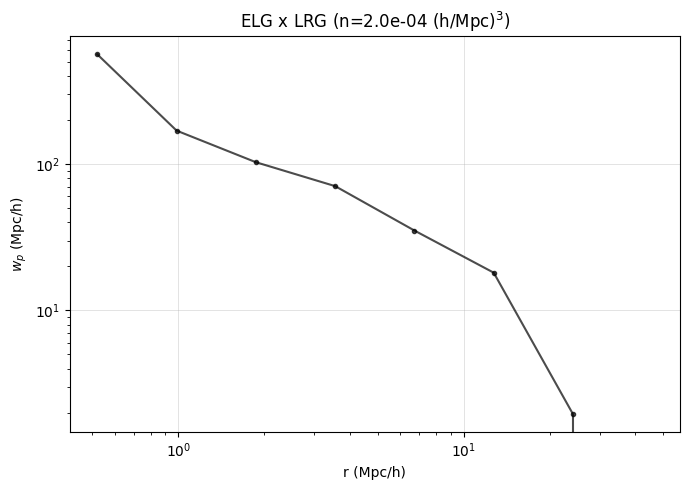

In [46]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(ravg, wp_cross, 'k.-', alpha=0.7)
ax.loglog()
ax.set_xlabel(r'r (Mpc/h)')
ax.set_ylabel(r'$w_p$ (Mpc/h)')
ax.grid(alpha=0.5, lw=0.5)
ax.set_title('ELG x LRG (n='f'{n:.1e} (h/Mpc)'r'$^3$)')

### angular cross-correlation

In [63]:
# prep for angular xcorr
dataforcf = corrfuncs.set_up_cf_data(gal_pos_elg, randmult, rpmin, rpmax, nbins,
                           data2=gal_pos_lrg, boxsize=sim.boxsize, logbins=True)
rp_edges, rp_avg, nd1, nd2, boxsize, nr, rand_set, d1_set, d2_set = dataforcf.values()

# convert to (RA, Dec)
chi = tools.redshift_to_comov(sim.redshift)

ra_elg, dec_elg = tools.get_ra_dec(d1_set, chi)
ra_lrg, dec_lrg = tools.get_ra_dec(d2_set, chi)
ra_rand, dec_rand = tools.get_ra_dec(rand_set, chi)

# and convert bin edges to angles
theta_edges = tools.r_comov_to_theta(rp_edges, sim.redshift).value

Text(0.5, 1.0, 'ELG and LRG, z=1.0, n=2.0e-04')

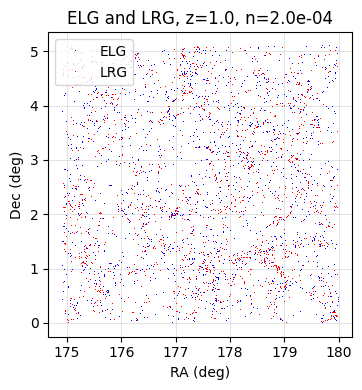

In [59]:
# plot
fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)

ax.plot(ra_elg, dec_elg, c='b', marker=',', ls='None', label='ELG')
ax.plot(ra_lrg, dec_lrg, c='r', marker=',', ls='None', label='LRG')
ax.grid(alpha=0.5, lw=0.5)
ax.set_aspect('equal')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.legend()
ax.set_title(f'ELG and LRG, z={sim.redshift:.1f}, n={n:.1e}')

In [65]:
thetaavg, wtheta = corrfuncs.wtheta_cross_PH(ra_elg, dec_elg,
                                         ra_lrg, dec_lrg, ra_rand, dec_rand, theta_edges)

Text(0.5, 1.0, 'ELG x LRG, z=1.0 (n=2.0e-04 (h/Mpc)$^3$)')

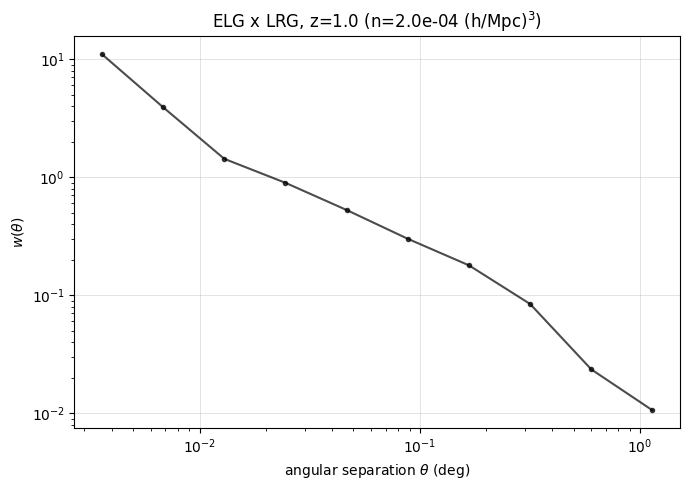

In [67]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(thetaavg, wtheta, 'k.-', alpha=0.7)
ax.loglog()
ax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.set_ylabel(r'$w(\theta)$')
ax.grid(alpha=0.5, lw=0.5)
ax.set_title(f'ELG x LRG, z={sim.redshift} (n={n:.1e} (h/Mpc)'r'$^3$)')